# Model structuur
*Auteurs: R.A. Collenteur (Universiteit Graz)*

Een belangrijke stap in tijdreeksanalyse is het bepalen van de modelstructuur van het tijdreeksmodel. Dit is het onderwerp van dit Notebook. We beperken ons hier tot het bepalen van het deterministische deel van het model. Het bepalen van het ruismodel is onderdeel van het notebook over modelkalibratie. In dit notebook wordt een overzicht gegeven van de verschillende opties die mogelijk zijn voor de modelstructuur.

### Inhoudsopgave

- [Basis model structuur](Basis-model-structuur)
- [Response functies](#Respons-functies)
- [Effect van neerslag en verdamping](#Effect-van-neerslag-en-verdamping)
- [Drempel niet-lineariteit](#Drempel-niet-lineariteit)
- [Rivieren en ontrekkingen](#Rivieren-en-ontrekkingen)
- [Veranderingen in het systeem](#Veranderingen-in-het-systeem)
- [Bepalen van invloeden](#Verklarende-variabelen)
- [Discussie](#Discussie)
- [Referenties](#Referenties)

## Algemeen stappenplan
Voor het kiezen van de gewenste modelstructuur is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Wanneer het doel van de modellering is vastgesteld, kunnen de volgende stappen worden doorlopen:

1. **Systeem analyse**: bepaal mogelijke hydrologische variabelen,
2. **Model bouw**: bepaal hoe deze variabelen worden omgezet in fluctuaties,
3. **Controle**: bepaal welke variabelen daadwerkelijk invloed hebben.

We gaan ervan uit dat de eerste stap al is uitgevoerd en bespreken de tweede en derde stap. Eerst wordt een overzicht gegeven van de bouwstenen die beschikbaar zijn om een model te bouwen. Daarna kijken we naar methoden om te bepalen welke bouwstenen nodig zijn in een model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec
import geopandas as gpd
import contextily as ctx

ps.set_log_level("ERROR")
#ps.show_versions()

## Basis model structuur
Het tijdreeksmodel kan in zijn meest algemene vorm als volgt worden beschreven:

$$ h(t) = \sum_{m=0}^M h_m(t) + d + r(t) $$

Waar $h(t)$ de gemeten stijghoogte is, $h_m(t)$ de bijdrage van invloed $m$, $d$ het basisniveau van het model, en $r(t)$ de modelresiduen. Er kunnen meerdere invloeden $m$ bijdragen aan de stijghoogte fluctuaties in de stijghoogte. In dit notebooks gaat het voornamelijk over het bepalen van deze bijdragen, en of en hoe een hydrologische variabele moet worden meegenomen in het model. Eerst volgt een korte uitleg over de constante $d$.

### Het basisniveau van het model
Vrijwel elk tijdreeksmodel bevat een constante (bv. $d$) waarmee het model op de juiste hoogte wordt gebracht. Hoewel verleidelijk, is het niet altijd juist een fysische betekenis aan deze constante toe te kennen. In de literatuur wordt soms verwezen naar de drainagebasis, het niveau waar het grondwater na verloop van tijd naar zou convergeren wanneer alle invloeden nul zijn. Of deze interpretatie juist is hangt echter af van het exacte model. Beter is daarom om eenvoudig naar $d$ te verwijzen als het basisniveau van het model.

Voor het bepalen van de waarde van de constante zijn verschillende methoden beschikbaar. De eerste 
optie is om na een simulatie het gemiddelde van de residuen te nemen als waarde voor $d$ (e.g., [von Asmuth et al., 2002](#Referenties)). Een andere optie is om $d$ mee te schatten als een parameter (e.g., [Collenteur et al. 2019](#Referenties)). Dit heeft als voordeel dat er ook iets gezegd kan worden over de onzekerheid van deze parameter. Meer onderzoek is nodig om vast te stellen wat het effect is van het verschil tussen deze twee methoden om de uiteindelijke resultaten.

### Bijdragen
Stijghoogte fluctuaties kunnen door vele verschillende oorzaken ontstaan. Vaak hebben we een idee welke oorzaken belangrijk zijn, maar net zo vaak is dit juist het doel van de modellering. Wat het exacte effect van een bepaalde invloed kan afhangen van de gekozen vorm van de modellering, oftewel hoe de invloed vertaald wordt in een bijdrage aan de stijghoogte fluctuaties. 

We kunnen twee typen invloeden onderscheiden: gemeten en niet gemeten invloeden. Voor gemeten invloeden zijn verklarende tijdreeksen beschikbaar om de bijdrage van een invloed aan de stijghoogte fluctuaties te bepalen. Dit zijn bijvoorbeeld: neerslag, potentiele verdamping, ontrekkingen, oppervlakte waterstanden en luchtdruk metingen. Dit type invloeden kan worden vertaald in een bijdrage met behulp van een impuls respons functie.

Voor niet gemeten invloeden zijn (vaak)geen verklarende tijdreeksen beschikbaar en het effect van dit type invloeden is lastiger vast te stellen. Voorbeelden zijn veranderend landgebruik, ingreep in de waterhuishouding (bv. opzet Ijsselmeer). Dit type bijdrage kan worden meegenomen door een trend mee te nemen in de modellering. De op te geven informatie is in dit geval een periode of tijdstap wanneer een verandering heeft plaats gevonden.

## Respons functies
De vertaling van een verklarende tijdreeks naar een bijdrage aan de stijghoogte fluctuaties kan worden gedaan met behulp van een impuls respons functies. De impuls respons functie beschrijft in dit geval hoe de stijghoogte reageert op een impuls van de verklarende tijdreeks. Er zijn tal van respons functies die kunnen worden gekozen om een verklarende tijdreeks om te zetten in een bijdrage aan de stijghoogte fluctuaties. De keuze voor een bepaalde respons functie kan bijvoorbeeld afhangen van het type verklarende reeks (bv. neerslag of een rivier), maar ook van het systeem (bv. een dikke of dunne overzadigde zone).

Vaak wordt een 4-parameter gamma functie of een vereenvoudigde vorm daarvan gebruik als impuls respons functie. Afhankelijk van het systeem kunnen bepaalde parameters worden vastgezet, wat het aantal te schatten parameters verlaagt. In de volgende figuur worden drie impuls respons functie getoond die elk een vereenvoudigde vorm van de 4-parameter gamma functie zijn.

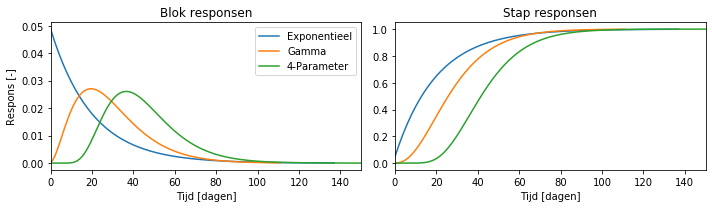

In [2]:
# Voorbeeld van Gamma respons functie waar n=1, en hetzelfde model met een exponentiele functie

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

rfuncs = [ps.Exponential, ps.Gamma, ps.FourParam]
params = [[1, 20], [1, 3, 10], [1, 2, 10, 10]]

for rfunc, param in zip(rfuncs, params):
    rfunc = rfunc(up=True)
    p = rfunc.get_init_parameters("p")
    ax1.plot(rfunc.block(param))
    ax2.plot(rfunc.step(param))
ax1.set_xlim(0, 150)
ax1.set_title("Blok responsen")
ax2.set_title("Stap responsen")
ax1.set_xlabel("Tijd [dagen]")
ax2.set_xlabel("Tijd [dagen]")
ax1.set_ylabel("Respons [-]")
ax1.legend(["Exponentieel", "Gamma", "4-Parameter"]);
plt.tight_layout()

De exponentiele respons heeft 2 parameters, de Gamma heeft 3 parameters, en de 4-parameter gamma functie heeft 4 parameters. Het kan echter goed voorkomen dat de parameters van de 4-parameter functie na kalibratie eigenlijk een Gamma of zelfs exponentiele functie simuleren. Het is dan mogelijk parameters vast te zetten en op die manier het aantal te schatten parameters te reduceren. Het dient over het algemeen aanbeveling verschillende respons functies te testen. Per software pakket dient te worden bepaalt welke respons functies beschikbaar zijn.

## Effect van neerslag en verdamping

Vrijwel alle grondwaterstanden in Nederland worden in meer of mindere mate beinvloed door neerslag en verdamping. Deze twee verklarende tijdsreeksen worden daarom bijna altijd in een tijdreeksmodel opgenomen. De manier waarop deze tijdreeksen worden meegenomen in het model kunnen sterk verschillen. We kunnen grofweg drie methoden onderscheiden: 

- Neerslag en verdamping als aparte invloeden
- Netto neerslagoverschot ($N = P-fE$) en 1 respons functie 
- Niet-lineaire grondwateraanvulling en 1 respons functie

### Voorbeeld data
In de volgende drie secties wordt een model gemaakt volgens deze drie methoden. De stijghoogte tijdreeks die in dit voorbeeld is gebruikt is gemeten in een monitorings put B32C0639 (filter 1) nabij de Bilt. Neerslag en potentiele Makkink verdamping is beschikbaar van het KNMI meteorologisch meetstation de Bilt.

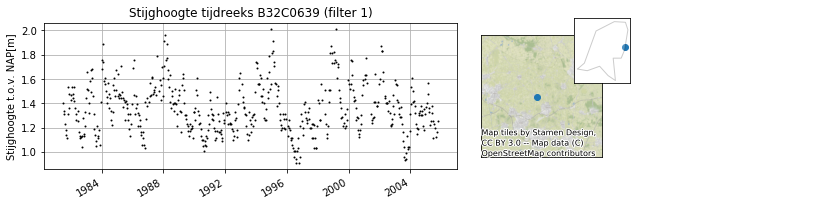

In [3]:
head = pd.read_csv("data/B32C0639001.csv",  parse_dates=['date'], index_col='date', squeeze=True)

fig = plt.figure(figsize=(10,3))

gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])

ax2.set_xticks([])
ax2.set_yticks([])
ax3 = plt.axes([0.85, 0.60, 0.1, 0.3])
ax3.set_xticks([])
ax3.set_yticks([])

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(epsg=3857)
world[world.name == "Netherlands"].plot(ax=ax3, color="w", edgecolor='black', 
                                        zorder=10, alpha=0.2)
import pyproj
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
x, y = transformer.transform(52.34414110341375, 6.875162288221905)

ax2.plot(x, y, marker="o")
ax3.plot(x, y, marker="o")

i = 30000
ax2.set_xlim(x - i, x + i)
ax2.set_ylim(y - i, y + i)
ctx.add_basemap(ax2, reset_extent=False)

head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()

ax1.set_title("Stijghoogte tijdreeks B32C0639 (filter 1)")
ax1.set_ylabel("Stijghoogte t.o.v. NAP[m]")
ax1.set_xlabel(" ");
#plt.tight_layout()

### Neerslag en verdamping als aparte invloeden
Bij deze methode worden de twee tijdreeksen van neerslag en verdamping onafhankelijk van elkaar meegenomen in het tijdreeksmodel. Door middel van twee aparte (en wederom onafhankelijke) responsfuncties worden de tijdreeksen vertaald in bijdragen aan de stijghoogte fluctuaties. Hieronder is een voorbeeld gegeven van het resultaat van een dergelijk model voor de voorbeeld data.

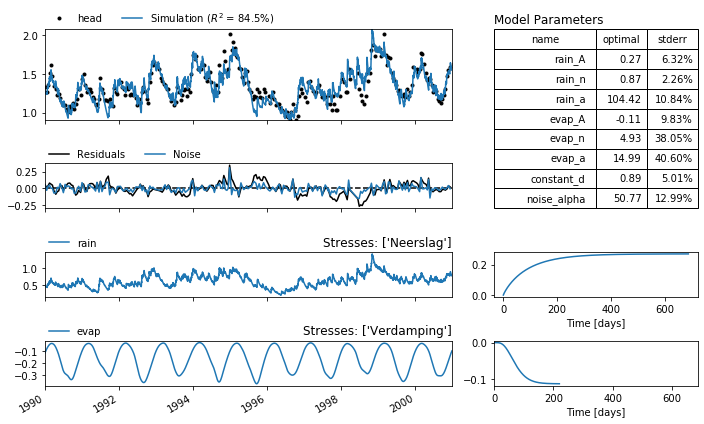

In [4]:
# Voorbeeld van neerslag en verdamping met aparte respons functies
head = pd.read_csv("data/B32C0639001.csv",  parse_dates=['date'],
                   index_col='date', squeeze=True)
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

tmin = "1990"
tmax = "2001"

# Create the basic Pastas model
ml1 = ps.Model(head, name="2 responsen")

# Add a recharge model
rm1 = ps.StressModel(rain, rfunc=ps.Gamma, name="rain", up=True)
rm2 = ps.StressModel(evap, rfunc=ps.Gamma, name="evap", up=False)

ml1.add_stressmodel([rm1, rm2])

# Solve the model
ml1.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml1.plots.results(figsize=(10, 6));

De onderste twee linker subplots tonen de geschatte invloed van de neerslag en de verdamping. De neerslag heeft een positief (stijgend) effect op de stijghoogte en de verdamping een dalend effect. Voor beide respons functies (zie de onderste twee rechter subplots) moeten de parameters worden geschat. Het totaal aantal geschatte parameters van dit model is 8.

### Lineair neerslagoverschot
Een veelgemaakte aanname is dat de respons van de stijghoogte op neerslag en verdamping vergelijkbaar is, maar in de tegenovergestelde richting. Hoewel uit bijvoorbeeld bovenstaande figuur blijkt dit niet altijd het geval is, is in de praktijk gebleken dat deze aanname toch vaak goede modellen oplevert. Onder deze aanname is het mogelijk eerst het neerslagoverschot te berekenen ($N = P - E$) en deze flux te vertalen in een bijdrage aan de stijghoogtefluctuaties met een enkele respons functie.

Omdat vaak gewerkt wordt met de potentiele verdamping (bijvoorbeeld Makkink of Penman-Monteith) wordt een verdampingsfactor $f$ gebruikt. Het neerslag overschot wordt dan berekend als : $N = P - f *E$, waar $f$ een kalibratie parameter is. Een belangrijk voordeel van dit model ten op zichte van het voorgaande model is het kleinere aantal parameters dat geschat moet worden.

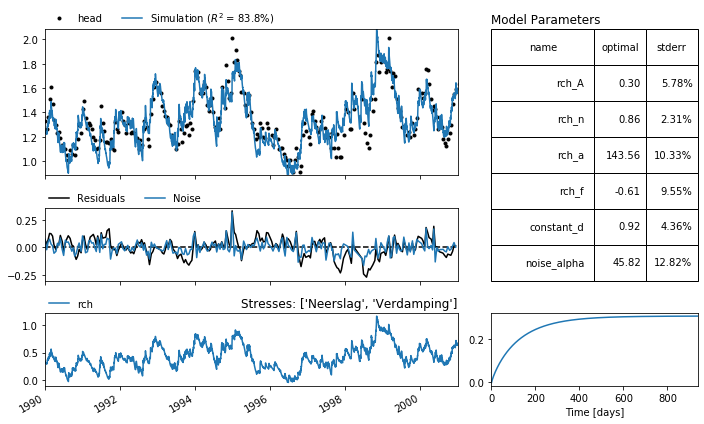

In [5]:
### Voorbeeld van netto neerslagoverschot (N = P-fE) en gamma respons functie

# Create the basic Pastas model
ml2 = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml2.add_stressmodel(rm)

# Solve the model
ml2.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml2.plots.results(figsize=(10, 6));

In de figuur hierboven is het resultaat van dit model voor de voorbeeld data getoond. De geschatte verdampingsfactor is $f=-0.61$. Terwijl dit model twee kalibratie parameters minder heeft is de model fit vrijwel gelijk aan het eerste model.

### Niet-lineaire grondwateraanvulling
Bij de derde methode wordt een niet-lineair model gebruikt om grondwateraanvulling te berekenen, die vervolgens ook geconvolueerd wordt met een respons functie. Verschillende niet-lineaire modellen zijn beschikbaar, zie bijvoorbeeld [Berendrecht et al. (2005)](#Referenties), [Peterson en Western (2014)](#Referenties) en [Collenteur et al. (2020)](#Referenties). Een voordeel van niet-lineaire modellen is dat er rekening wordt gehouden met processen in de onverzadigde zone, waardoor de stijghoogte niet meer lineair reageert op neerslag en verdamping. Dit gebeurt bijvoorbeeld wanneer de verdamping wordt beperkt door de de beschikbare bodemvocht ten tijd van droogte, of door de berging van neerslag in de onverzadigde zone. 

Voeg plaatje van bakjesmodellen toe (Berendrecht en Collenteur

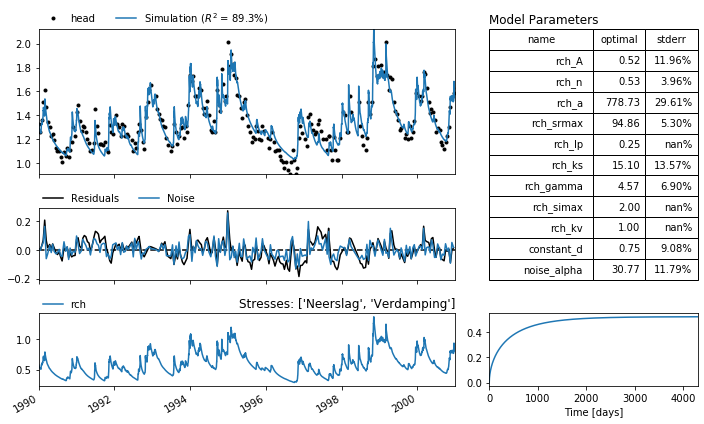

In [6]:
# Voorbeeld van Niet-lineaire grondwateraanvulling en exponentiele response functie
ml3 = ps.Model(head, name="niet-lineair")

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml3.add_stressmodel(rm)

# Solve the model
ml3.set_parameter("constant_d", initial=head.min())  # Start below the lowest head
ml3.solve(noise=True, tmin=tmin, tmax=tmax, initial=True, report=False)
ml3.plots.results(figsize=(10, 6));

Mogelijke nadelen van niet-lineaire modellen kunnen een groter aantal vrije parameters zijn of de rekentijd van het model. Het is echter vaak mogelijk een aantal parameters vast te zetten en een response functie te gebruiken met minder parameters, waardoor het aantal vrije parameters sterk is te reduceren. Door ontwikkelingen in de software is de rekentijd eigenlijk geen argument meer om niet-lineaire modellen niet te gebruiken.

### Welk model is het beste?
We hebben nu drie modellen voor een stijghoogte reeks die goed verklaart kan worden door neerslag en verdamping. Het model met twee aparte responsen heeft een $R^2=0.85$, het lineaire model $R^2=0.84$ en het niet-lineaire model $R^2=0.89$. De modellen ontlopen elkaar dus eigenlijk niet zo veel wat betreft deze fit statistiek. Het is aan de modelleur om nu een van deze modellen te kiezen of deze allemaal te gebruiken.

Een veelgebruikte methode om het "beste" model te selecteren is door de fit van de modellen buiten de kalibratieperiode te berekenen. In de figuur hieronder is met elk model de stijghoogte in voor een periode na de kalibratieperiode gesimuleerd (2001-2006). In de legenda is de determinatie coefficient weergegeven. Nu is het model met de twee responsen het beste model volgens de $R^2$ statistiek ($R^2=0.88$), en hebben het lineaire en niet-lineaire model een slechtere fit ($R^2=0.86$).

De model fits zijn in dit voorbeeld zeer vergelijkbaar. De modelleur kan er in dit geval bijvoorbeeld voor kiezen het model met het laagste aantal parameters te kiezen. Dit aantal is het laagste voor het lineaire model ($n=6$), en de andere twee modellen hebben beide meer parameters hebben (beide $n=8$).

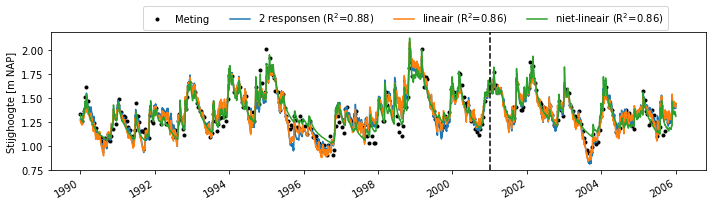

In [7]:
ax = ml1.oseries.series[tmin:].plot(marker=".", linestyle=" ", color="k", figsize=(10,3))

labels = ["Meting"]
for ml in [ml1, ml2, ml3]:
    ml.simulate(tmax="2006").plot()
    labels.append("{} (R$^2$={})".format(ml.name, ml.stats.rsq(tmin=tmax, tmax="2006").round(2)))
ax.axvline(pd.Timestamp(tmax), color="k", linestyle="--")
plt.legend(labels, ncol=4, bbox_to_anchor=(0.95, 1.22))
plt.ylabel("Stijghoogte [m NAP]");
plt.tight_layout()

### Dikke onverzadigde zone

- Voorbeeld van buis van Berendrecht en Collenteur

## Drempel niet-lineariteit
Een veelvoorkomend fenomeen in (lager gelegen) delen van Nederland is drempel niet-lineariteit (zie bv. [Berendrecht et al. (2004)](#Referenties)). Daarbij reageert een grondwatersysteem anders op een impuls (bv. neerslag) nadat een bepaalde grenswaarde in de stijghoogte is overschreden. [Knotters et al. (1999)](#Referenties) hebben hiervoor een model ontwikkeld, het zogeheten TARSO model, waarbij de respons op neerslagoverschot afhangt van de stijghoogte boven of onder een bepaalde drempelwaarde. Wanneer de stijghoogte boven deze drempelwaarde komt, kan het bijvoorbeeld zo zijn dat afstroming naar het oppervlaktewater plaats vind (bv. een sloot die anders droog staat). Of er sprake is van drempel niet-lineariteit kan worden vastgesteld door:

1. een visuele inspectie of de stijghoogte tijdreeks afgevlakt is, 
3. het plotten van een histogram van de stijghoogte metingen, of
2. het testen van verschillende modelstructuren.

---

Als voorbeeld kijken we naar een stijghoogte reeks B28H1804 (filter 2) in de buurt van Weerselo. De gegevens in Dinoloket laten zien dat het maaiveeld bij ditpunt of 19.44 meter t.o.v. NAP ligt. In onderstaande figuur is de stijghoogte tijdreeks en een histogram van de reeks afgebeeld voor een visuele inspectie van de tijdreeks (stap 1 & 2). 

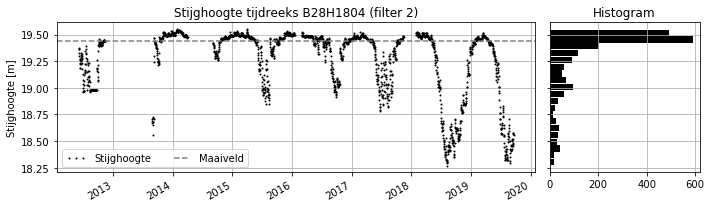

In [8]:
# Plot van tijdreeks waarbij sprake is van drempel niet lineariteit, inclusief histogram aan de zijkant 90 graden gedraaid.
head = ps.read_dino("data/B28H1804001_1.csv").series

fig = plt.figure(figsize=(10,3))

gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1], sharey=ax1)

head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax2.grid()
plt.hist(head, orientation="horizontal", bins=20, color="k", rwidth=0.9)
ax1.axhline(19.44, linestyle="--", color="gray")
ax1.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_title("Histogram");
ax1.legend(["Stijghoogte", "Maaiveld"], ncol=2, numpoints=3)
plt.tight_layout()

Uit bovenstaande plots is af te leiden dat er mogelijk sprake is van drempel niet-lineariteit. De stijghoogte reeks is afgevlakt rond 19.50-19.75 en de histogram laat een duidelijke scheve verdeling zien. Op basis van de visuele inspectie kunnen we bijvoorbeeld besluiten om twee modellen te testen: de eerste met een simpel neerslag overschot ($N = P - fE$) en een tweede met drempel niet-lineariteit (hier, het TARSO model). Vervolgens kan dan worden beoordeeld welk model "beter" is en wordt gebruikt voor verdere analyse.

Onderstaande figuur geeft de resultaten van de twee modellen weer. Het lineaire model geeft een structurele overschatting van de hoge grondwaterstanden, waar het drempel niet-lineaire model netjes de gemeten grondwaterstand volgt.

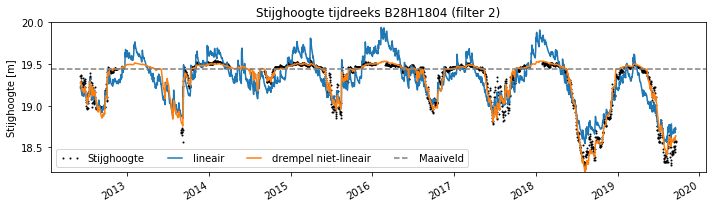

In [9]:
prec = pd.read_csv("data/RD Weerselo.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
evap = pd.read_csv("data/EV24 Twenthe.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3

ml = ps.Model(head, name="B28H1804_2")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma, recharge=ps.rch.Linear())
ml.add_stressmodel(rm)
# the model is already solved, but we solve it again to be certain
ml.solve(noise=False, report=False)
sim = ml.simulate()

# Plot van lineair model versus een drempel niet-lineair model.
sm = ml.stressmodels['recharge']
prec = sm.stress[0]
evap = sm.stress[1]

# delete all the stressmodels, the constant and the transform
ml.del_stressmodel('recharge')
ml.del_constant()

# then add a TarsoModel
sm = ps.TarsoModel(prec, evap, ml.oseries)
ml.add_stressmodel(sm)

# and solve again
ml.solve(noise=False, report=False)

# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate().plot(ax=ax)
ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax.axhline(19.44, linestyle="--", color="gray")
ax.legend(["Stijghoogte",  "lineair", "drempel niet-lineair", "Maaiveld"], ncol=4, loc=3, numpoints=3);
plt.tight_layout()

## Andere verklarende variabelen
Tot op dit punt hebben we gekeken naar stijghoogte tijdreeksen die zich goed laten verklaren door neerslag en verdamping. In veel gevallen zijn echter andere verklarende tijdreeksen nodig om de stijghoogte goed te kunnen modelleren. Twee invloeden die vaak belangrijk zijn, zijn oppervlaktewaterpeilen en grondwaterontrekkingen. In de volgende twee secties wordt beschreven hoe de effecten van deze invloeden kunnen worden gemodelleerd.

### Oppervlaktepeil als verklarende tijdreeks
In grote delen van Nederland worden de stijghoogten beinvloed door oppervlaktewaterpeilen. Dit kunnen grote rivieren en meren als de Rijn en het Ijsselmeer zijn, maar ook kleinere vennen en slootjes in de polder. Het is niet ongebruikelijk dat het nodig is een tijdreeks van een nabijgelegen oppervlaktewaterpeil toe te voegen aan het tijdreeksmodel om de stijghoogte goed te kunnen modeleren. 

We kunnen dit wederom doen door de tijdreeks van het gemeten oppervlaktewaterpeil te vertalen naar een bijdrage aan de stijghoogtefluctuaties met behulp van een respons functie. De repons functie beschrijft dan de reactie van de stijghoogte op fluctuaties in het oppervlaktewaterpeil. Het is aan te bevelen om deze tijdreeks eerst te normaliseren door bijvoorbeeld het gemiddelde om de mediaan er van af te trekken. We zijn immers enkel geintereseerd in de veranderingen in het oppervlaktewaterpeil en niet in het absolute niveau. Meer informatie over normaliseren van tijdreeksen is te vinden in het hoofdstuk over [Voorbewerking](#Voorbewerking).

---

Als voorbeeld modeleren we de stijghoogte tijdreeks gemeten in peilbuis 40CP0393 (filter 4). Eerst maken we een model met enkel neerslag en verdamping als verklarende variabelen. Deze worden vertaald in stijghoogte fluctuaties met een lineair neerslagoverschot model en een Gamma respons functie. Dit model levert de volgende simulatie van de stijghoogte op.

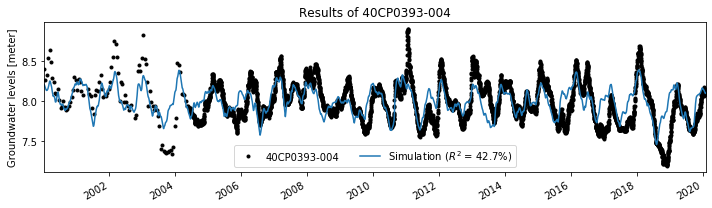

In [35]:
# Code met dit model hier
head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True, squeeze=True).resample("D").mean().dropna()
prec = pd.read_csv("data/RD_Nijmegen.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("data/EV24_Deelen.csv", index_col=0, parse_dates=True)

ml = ps.Model(head, name="40CP0393-004")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)

ml.solve(report=False)
ml.plot(figsize=(10, 3));
plt.tight_layout()

Uit bovenstaande figuur blijkt duidelijk dat het neerslagoverschot niet genoeg is om de stijghoogte fluctuaties te verklaren. Uit de hydrologische systeem analyse van het studiegebied blijkt dat de peilbuis dichtbij een oppervlaktewaterlichaam ligt. We kunnen dan de rivierwaterstand als verklarende tijdreeks aan het model toevoegen en kijken of dit de simulatie van de stijghoogte verbetert. We kiezen hier voor de algemene Gamma respons functie met drie parameters om het oppervlaktewaterpeil te vertalen in stijghoogtefluctuaties.

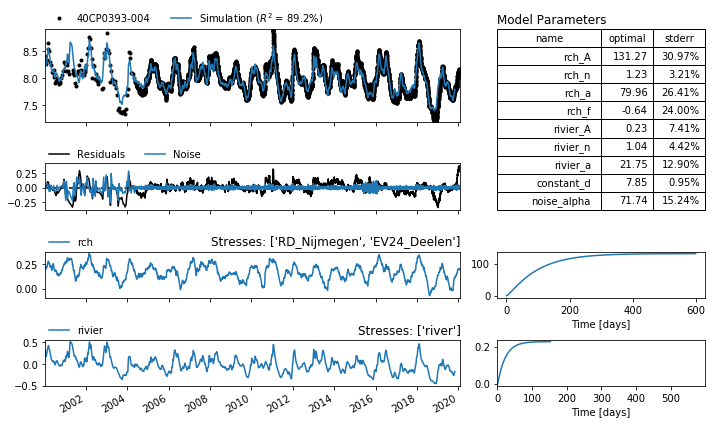

In [36]:
rivier = pd.read_csv("data/40CP0393-rivier.csv", index_col=0, parse_dates=True, squeeze=True)
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)

ml.solve(report=False)
ml.plots.results(figsize=(10, 6));
plt.tight_layout()

Het model laat een duidelijke verbetering zien in de fit tussen de gesimuleerde en de gemeten stijghoogte. De fit, hier uitgedrukt als $R^2$, is gestegen van $R^2=0.43$ naar $R^2=0.89$. Het toevoegen van het oppervlaktewaterpeil levert hier dus een duidelijke verbetering op.

De gekalibreerde respons functie lijkt erg op een exponentiele respons functie, te zien aan de blok respons en de waarde van parameter $rch\_n$ die bijna 1 is. Dit betekend dat de stijghoogte vrijwel instantaan reageert op de rivierwaterstand. Wanneer dit het geval, verdient het aanbeveling de Gamma respons functie te vervangen door de exponentiele respons functie. Dit scheelt 1 kalibratie parameter in het model, en levert hetzelfde model op. Wanner de fit gelijk is, zal een model met minder parameters over het algemeen de voorkeur hebben over een model met meer parameters. Onderstaande figuur toont het model waar gebruikt is van een exponentiele respons functie in plaats van de Gamma. Het resultaat laat zien dat dit een vergelijkbaar model oplevert, maar met 1 parameter minder. 

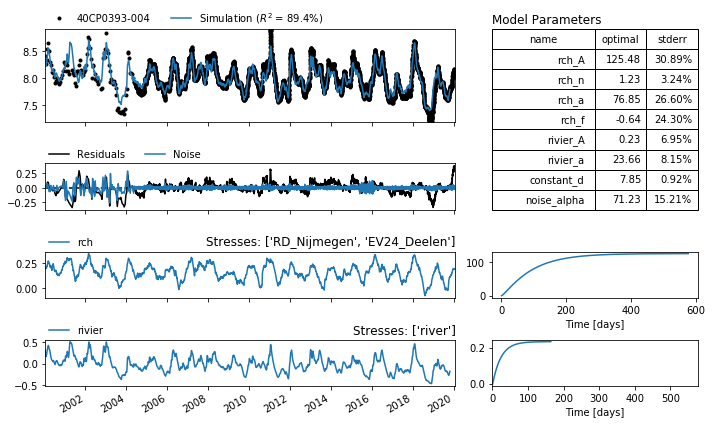

In [37]:
ml.del_stressmodel("rivier")
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Exponential)
ml.add_stressmodel(sm2)

ml.solve(report=False)
ml.plots.results(figsize=(10, 6));
plt.tight_layout()

Zowel de grondwateraanvulling (of natuurlijk het natuurslagoverschot) als het oppervlaktewaterpeil is in zekere mate afhankelijk van de neerslag. Dit kan er voor zorgen dat de parameters van deze modelonderdelen sterk gecorreleerd zijn en de  bijdragen aan de stijghoogte fluctuaties lastig van elkaar te onderscheiden zijn. Wanneer veranderingen in het oppervlaktewaterpeil net als grondwateraanvulling veroorzaakt wordt door lokale neerslag, kan het zijn dat de bijdragen aan de 

In [38]:
bijdrage_rivier = ml.get_contribution("rivier")
bijdrage_rch = ml.get_contribution("rch")

bijdrage_rch.corr(bijdrage_rivier)

0.661691011113534

### De invloed van een grondwaterontrekking bepalen

- tijdreeks in model meenemen
- response functies testen, gamma en hantush

### Meerdere grondwaterontrekkingen
- Meerdere grondwaterontrekkingen
- Wat als reeksen gecorreleerd zijn?


## Veranderingen in het systeem
Systemen kunnen niet allen veranderen als gevolg van de grondwaterstand (bv. drempel niet-lineariteit), maar ook als gevolg van systeemsveranderingen door de tijd.

- Stap response
- Lineaire trend
- Veranderende respons functies (Obergfjell et al. (2019)).

### Stap response



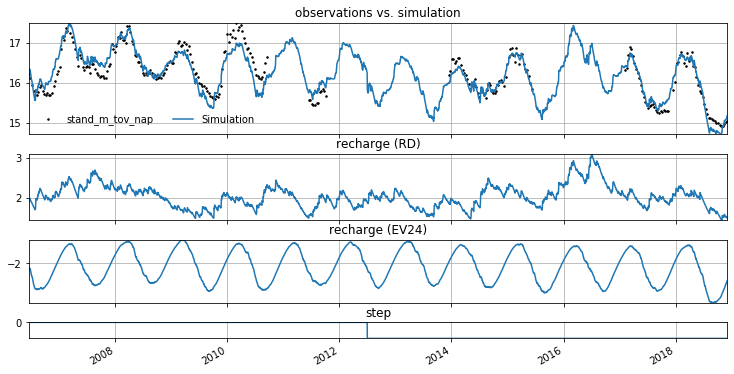

In [13]:
# Voorbeeld van model met stap respons
p = pd.read_csv("data/RD Helmond.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
e = pd.read_csv("data/EV24 Eindhoven.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
h = pd.read_csv("data/B51G2150-001.csv", index_col=0, parse_dates=True, squeeze=True)

# Maak een model
ml = ps.Model(h.iloc[::10])

# Voeg stress modellen toe
sm = ps.RechargeModel(p, e, name="recharge", rfunc=ps.Exponential, recharge=ps.rch.Linear())
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="step", up=False)
ml.add_stressmodel([sm, step])

# Kalibreer het model en toon de resultaten
ml.solve(noise=True, report=False)
ml.plots.decomposition(figsize=(10,5));

### Voorbeeld van een model met lineaire trend
Het gebeurt vaak dat een stijghoogte tijdreeks een opwaarste of neerwaartse trend vertoond, die niet door neerslag of verdamping verklaart kan worden. We beschouwen hier een model voor het 1e filter in de peilbuis "B32C0609" nabij de Bilt. Als eerste stap maken we een model met neerslag en verdamping als verklarende variabelen.

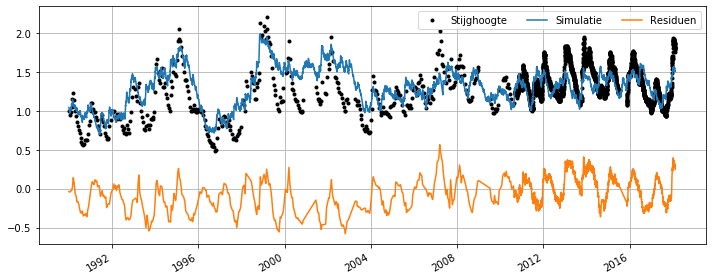

In [14]:
# Loads heads and create Pastas model
head2 = ps.read_dino("data/B32C0609001_1.csv")
ml2 = ps.Model(head2, name="Stijghoogte")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml2.add_stressmodel(rm)

# Solve and plot the model
ml2.solve(noise=False, tmin="1990", report=False)

# Plot het model
ax = ml2.observations().plot(linestyle=" ", marker=".", color="k", figsize=(10, 4));
ml2.simulate().plot()
ml2.residuals().plot()
ax.grid()
plt.legend(["Stijghoogte", "Simulatie", "Residuen"], ncol=3)
plt.tight_layout()

In de figuur hierboven is het resultaat van de modellering te weergegeven. We zien dat het model de fluctuaties in de gemeten stijghoogte in het algemeen goed kan verklaren, maar de residuen van het model laten een duidelijke opwaarste trend zien. Het model overschat de stijghoogte in het begin van de kalibratie periode en onderschat de stijghoogte aan het einde van deze periode. 

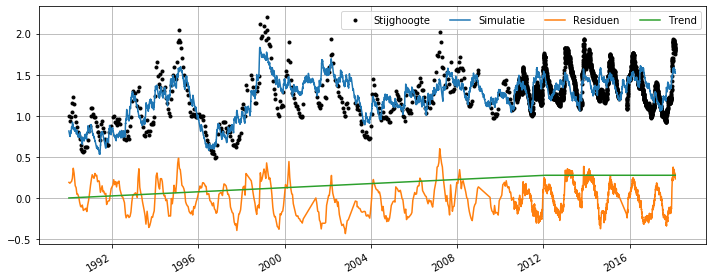

In [15]:
# Add a linear trend
tm = ps.LinearTrend(start="1990", end="2012", name="trend")
ml2.add_stressmodel(tm)

# Solve the model
ml2.solve(noise=False, tmin="1990", initial=False, report=False)

# Plot het model
ax = ml2.observations().plot(linestyle=" ", marker=".", color="k", figsize=(10, 4));
ml2.simulate().plot()
ml2.residuals().plot()
ml2.get_contribution("trend").plot()
ax.grid()
plt.legend(["Stijghoogte", "Simulatie", "Residuen", "Trend"], ncol=4)
plt.tight_layout()

## Verklarende variabelen
Welke verklarende variabelen moeten worden meegenomen 

- Toetsen van hydrologische plausibiliteit van evenwichtsrelatie (bv. well_A > 0), diagnostisch toetsen noodzakelijk
- Lengte van de respons functie
- Residuen analyse


In [16]:
# Voorbeeld van model met pompput en zonder, significante well_A en niet

In [17]:
# Voorbeeld van residuen met een duidelijk trend, alpha >>> groot

## Discussie

- Invloed van de meetfrequentie (zie ook bv.  Herwijenen 2001)
- Correlaties tussen reeksen
- Wat als het sneeuwt
- Verdamping die verandert over de tijd
- Constante die niet constant is (door de tijd)
- Einstein, "everything should be as simple as possible, but not simpler."
Occums razor


## Referenties

- Knotters M. en de Gooijer, J.G. (1999) TARSO modeling of water table depths. Water Resources Research, 35:3.
- Berendrecht, W., Gehrels, H., van Geer, F., en Heermink, A. (2004) Een niet-lineair tijdreeksmodels voor grondwaterstandsfluctuaties in gedraineerde gebieden. Stromingen 10, nummer 2.
- von Asmuth et al. (2002)
- Berendrecht et al. (2006)
- Peterson and Western (2014)
- Collenteur et al. (2020)


## Beschikbaarheid van opties
In de volgende tabel wordt een overzicht gegeven welke opties in verschillende software pakketten beschikbaar zijn. **Dit overzicht komt niet in dit Notebook**

|Optie|Pastas|Menyanthes|Hydrosight|
|--|--|--|--|
|Drempel niet-lineariteit|Ja|Ja|Nee|
|niet-lineaire grondwateraanvulling|Ja|Nee|Ja|
|Stap respons|Ja|Ja|Onbekend|
|Lineaire trend|Ja|Ja|Onbekend|
|Veranderende respons|Nee|Nee|Nee|